# <font color='#FFE15D'>Decision Tree: C4.5</font>

## **🟪 Imports**

In [1]:
import pandas as pd
import numpy as np

from scipy.stats import mode
from graphviz import Digraph
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import KBinsDiscretizer
import copy
from collections import Counter

### Model

#### 🟨 Entropy

In [2]:
def entropy(labels):
  p = labels.value_counts() / len(labels)
  return -sum(p * np.log2(p + 1e-10))

#### 🟨 Information Gain

In [3]:
def information_gain(data, feature, target, threshold=None):
    # entropy of parent
    entropy_parent = entropy(data[target])

    entropy_child = 0
    # numerical feature
    if threshold is not None:

        left_subset = data[data[feature] <= threshold]
        right_subset = data[data[feature] > threshold]
        subsets = [left_subset, right_subset]

        for subset in subsets:
          wi = len(subset) / len(data)
          entropy_child += wi * entropy(subset[target])
        return entropy_parent - entropy_child

    # categorical feature
    else:
        for value in data[feature].unique():
            if pd.isnull(value):
               subset = data[data[feature].isnull()]
            else:
              subset = data[data[feature] == value]

            if len(subset) != 0:
              wi = len(subset) / len(data)
              entropy_child += wi * entropy(subset[target])
            else:
              entropy_child = 0
        return entropy_parent - entropy_child

#### 🟨 Gain Ratio

In [4]:
def calculate_gain_ratio(data, feature, target, threshold=None):
    # entropy of parent
    entropy_parent = entropy(data[target])

    entropy_child = 0
    # numerical feature
    if threshold is not None:

        left_subset = data[data[feature] <= threshold]
        right_subset = data[data[feature] > threshold]

        subsets = [left_subset, right_subset]

        weights = []
        for subset in subsets:
          wi = len(subset) / len(data)
          weights.append(wi)
          entropy_child += wi * entropy(subset[target])
        information_gain = entropy_parent - entropy_child

        split_info = 0
        for weight in weights:
            if weight != 0:
              split_info += -(weight * np.log2(weight))

        return information_gain / split_info if split_info != 0 else 0

    # categorical feature
    else:
        weights = []
        for value in data[feature].unique():

            if pd.isnull(value):
               subset = data[data[feature].isnull()]
            else:
              subset = data[data[feature] == value]

            wi = len(subset) / len(data)
            weights.append(wi)
            entropy_child += wi * entropy(subset[target])

        information_gain = entropy_parent - entropy_child

        split_info = 0
        for weight in weights:
            if weight != 0:
               split_info += -(weight * np.log2(weight))

        return information_gain / split_info if split_info != 0 else 0

#### 🟨 Best Threshold

In [5]:
def find_best_threshold(data, feature, target):

    best_threshold = None
    best_gain_ratio = -np.inf

    thresholds = data[feature].unique()
    for threshold in thresholds:
        gain_ratio = calculate_gain_ratio(data, feature, target, threshold)

        if gain_ratio > best_gain_ratio:
              best_gain_ratio = gain_ratio
              best_threshold = threshold

    return best_threshold

#### 🟩 Node

In [6]:
class Node:

    def __init__(self, feature=None, label=None, count=0):
        self.feature = feature
        self.label = label
        self.count = count
        self.children = {}

    def to_xml(self, indent="  "):
        if self.feature is not None:
            children_xml = ""
            for value, child in self.children.items():
                children_xml += f'\n{indent}  <DecisionBranch value="{value}">'
                children_xml += f'\n{child.to_xml(indent + "    ")}'
                children_xml += f'\n{indent}  </DecisionBranch>'
            return f'{indent}<DecisionNode feature="{self.feature}">{children_xml}\n{indent}</DecisionNode>'
        else:
            return f'{indent}<LeafNode label="{self.label}" count="{self.count}" />'



    def colorize(self, xml_str):
        # Define ANSI escape codes
        feature_color = '\033[94m'  # Blue
        label_color = '\033[92m'    # Green
        count_color = '\033[93m'    # Yellow
        reset_color = '\033[0m'     # Reset to default color

        # Replace tags with colored tags
        xml_str = xml_str.replace(f'<DecisionNode feature=', f'{feature_color}<DecisionNode feature={reset_color}')
        xml_str = xml_str.replace('<LeafNode label=', f'{label_color}<LeafNode label={reset_color}')
        xml_str = xml_str.replace(' count=', f' {count_color}count={reset_color}')

        return xml_str

    def __repr__(self):
        root_xml = self.to_xml("")
        colored_xml = self.colorize(root_xml)
        return f'<DecisionTree>\n{colored_xml}\n</DecisionTree>'

# <font color='#FFE15D'> 🟪 DecisionTreeClassification </font>

### 🟩 Pre-Prunning & Post-Pruning

In [7]:
class DecisionTreeClassification:

  def __init__(self, max_depth=None, min_samples_leaf=1, min_samples_split=2, discrete=None):
    self.max_depth = max_depth
    self.min_samples_leaf = min_samples_leaf
    self.min_samples_split = min_samples_split
    self.discrete = discrete

  def fit(self, data, target):
    self.data = data
    self.target = target
    return self._make_tree(data, target, depth=0)

  def _make_tree(self, data, target, depth):
      # leaf node?
      if len(data[target].unique()) == 1 or len(data[target]) <= self.min_samples_leaf:
        most_common_label = Counter(data[target]).most_common(1)[0]
        return Node(label=most_common_label[0], count=most_common_label[1])

      if self.max_depth != None:
        if depth >= self.max_depth:
          most_common_label = Counter(data[target]).most_common(1)[0]
          return Node(label=most_common_label[0], count=most_common_label[1])

      features = data.drop(target, axis=1).columns
      if len(features) == 0:
        most_common_label = Counter(data[target]).most_common(1)[0]
        return Node(label=most_common_label[0], count=most_common_label[1])

      if len(data) == 0:
        return Node(label='Fail')

      # calculate gain ratio and find best threshold
      gains, thresholds = [], []
      for feature in features:
        if data[feature].dtype == 'object' or data[feature].dtype == 'bool':
          gains.append(calculate_gain_ratio(data, feature, target))
          thresholds.append(None)

        else:
          best_t = find_best_threshold(data, feature, target)
          gains.append(calculate_gain_ratio(data, feature, target, best_t))
          thresholds.append(best_t)

      # greedy search to find best feature
      max_gain_ratio_idx = np.argmax(gains)
      best_feature = features[max_gain_ratio_idx]
      best_threshold = thresholds[max_gain_ratio_idx]

      # make a node
      if len(data[best_feature]) >= self.min_samples_split:
        node = Node(feature=best_feature)
      else:
        most_common_label = Counter(data[target]).most_common(1)[0]
        return Node(label=most_common_label[0], count=most_common_label[1])

      # split categorical data
      if data[best_feature].dtype == 'object' or data[best_feature].dtype == 'bool':
          if len(data[best_feature]) >= self.min_samples_split:
              for value in data[best_feature].unique():
                      if pd.isnull(value):
                          subset = data[data[best_feature].isnull()].drop(best_feature, axis=1)
                      else:
                          subset = data[data[best_feature] == value].drop(best_feature, axis=1)

                      if self.discrete != None:
                          node.children[value] = self._make_tree(subset, target, depth + 1)
                      else:
                          node.children[value] = self._make_tree(subset, target, depth + 1)

      # split numerical data using binary threshold
      else:
          if len(data[best_feature]) >= self.min_samples_split:
              left_subset = data[data[best_feature] <= best_threshold]
              right_subset = data[data[best_feature] > best_threshold]

              # find edge of bin of best threshold
              if self.discrete != None:
                    t = self.discrete.bin_edges_[self.discrete.feature_names_in_ == best_feature][0][int(best_threshold)+1]

                    node.children[f'<= {t}'] = self._make_tree(left_subset, target, depth + 1)
                    node.children[f'> {t}'] = self._make_tree(right_subset, target, depth + 1)

              else:
                    node.children[f'<= {best_threshold}'] = self._make_tree(left_subset, target, depth + 1)
                    node.children[f'> {best_threshold}'] = self._make_tree(right_subset, target, depth + 1)

      return node

  # prediction
  def predict(self, tree, sample):
    if tree.feature is None:
        return tree.label

    feature_value = sample[tree.feature]

    if feature_value in tree.children:
        return self.predict(tree.children[feature_value], sample)
    else:
        # handling numeric conditions
        for condition in tree.children:
            operator, threshold = condition.split(' ')
            threshold = float(threshold)

            if operator == '<=' and feature_value <= threshold:
                return self.predict(tree.children[condition], sample)
            elif operator == '>' and feature_value > threshold:
                return self.predict(tree.children[condition], sample)

  # calculate accuracy
  def accuracy(self, predictions, labels):
    return sum(pred == label for pred, label in zip(predictions, labels)) / len(labels)

  # applay predictions on the validation set and get accuracy
  def validate_tree(self, tree, validation_data):
    predictions = [self.predict(tree, sample) for _, sample in validation_data.iterrows()]
    labels = validation_data[target].tolist()
    return self.accuracy(predictions, labels)

  # find sub-tree of last internal node
  def find_last_sub_tree(self, node, parent=None):
    if node is None:
        return None

    if node.feature is not None:
        child_keys = list(node.children.keys())
        child_keys.reverse()
        for key in child_keys:
            last_internal = self.find_last_sub_tree(node.children[key], node)
            if last_internal is not None:
                return last_internal

    return node if node.feature is not None else None


  # find sub-tree and replace the matching sub-tree with a leaf node
  def temperory_prune_tree(self, root, sub_tree, new_label, new_count):
    if root is None:
        return

    # replace the matching sub-tree with a leaf node
    if repr(root) == repr(sub_tree):
        root.feature = None
        root.label = new_label
        root.count = new_count
        root.children = {}

    for child_key, child_node in root.children.items():
        self.temperory_prune_tree(child_node, sub_tree, new_label, new_count)
        g = self.visualize_tree(root)
        g.render(f'decision_car_{child_key}', format='png', view=True)
        self.visualize_tree(root)

    return root

  # get most common class
  def get_max_label_and_count(self, leaf_list):
    if not leaf_list:
        return None, 0

    label_counts = {}

    for leaf in leaf_list:
        if leaf.label is not None:
            if leaf.label in label_counts:
                label_counts[leaf.label] += leaf.count
            else:
                label_counts[leaf.label] = leaf.count

    if not label_counts:
        return None, 0

    max_label = max(label_counts, key=label_counts.get)
    max_count = label_counts[max_label]

    return max_label, max_count

  # reduced error prunning
  def post_prune(self, node, validation_data, validation_target):
         # leaf node, nothing to prune
         if node.feature is None:
           return node

         # recursively prune decision nodes
         for child_node in reversed(list(node.children.keys())):
           node.children[child_node] = self.post_prune(node.children[child_node], validation_data, validation_target)

         original_tree = copy.deepcopy(node)

         # accuracy before prunning
         original_accuracy = self.validate_tree(original_tree, validation_data)

         # sub-tree of last internal node
         sub_tree = self.find_last_sub_tree(node)

         # get most common class
         label_list = list(sub_tree.children.values())
         new_label, new_count = self.get_max_label_and_count(label_list)

         # temporarily remove sub-tree for pruning
         prune_tree = self.temperory_prune_tree(node, sub_tree, new_label, new_count)

         # accuracy after prunning
         pruned_accuracy = self.validate_tree(prune_tree, validation_data)

         # restore the pruned node, if pruning not improve accuracy
         if pruned_accuracy < original_accuracy:
            node = original_tree

         return node

  # plot tree
  def visualize_tree(self, tree, parent=None, node_id=None):
    if node_id is None:
        node_id = '0'
        g = Digraph(node_attr={'shape': 'record', 'height':'.1'})
        g.node(node_id, label=tree.feature, style='filled', fillcolor='burlywood')

    else:
        g = parent
        g.node(node_id, label=tree.feature, style='filled', fillcolor='#a0522d')

    if len(tree.children) == 0:
        g.node(node_id, label=tree.label, style='filled', fillcolor='forestgreen')
        return g

    for i, (value, child) in enumerate(tree.children.items()):
        child_id = f'{node_id}_{i+1}'
        self.visualize_tree(child, g, child_id)
        g.edge(node_id, child_id, label=str(value))

    return g

### 🟧 Data

In [19]:
data = pd.read_csv('iris.csv')
target = 'class'

data_train, data_test = train_test_split(data, test_size=0.25, stratify=data[target], random_state=5)
data_train.shape, data_test.shape

((112, 5), (38, 5))

In [20]:
data_train, data_valid = train_test_split(data_train, test_size=0.25, stratify=data_train[target], random_state=5)
data_train.shape, data_valid.shape

((84, 5), (28, 5))

### 🟩 Tree

In [21]:
clf = DecisionTreeClassification(discrete=None)
tree_iris = clf.fit(data_train, target)
tree_iris

<DecisionTree>
<DecisionNode feature="petal-length">
  <DecisionBranch value="<= 1.9">
    <LeafNode label="Iris-setosa" count="28" />
  </DecisionBranch>
  <DecisionBranch value="> 1.9">
    <DecisionNode feature="petal-width">
      <DecisionBranch value="<= 1.6">
        <DecisionNode feature="petal-length">
          <DecisionBranch value="<= 4.9">
            <LeafNode label="Iris-versicolor" count="26" />
          </DecisionBranch>
          <DecisionBranch value="> 4.9">
            <DecisionNode feature="sepal-width">
              <DecisionBranch value="<= 2.2">
                <LeafNode label="Iris-virginica" count="1" />
              </DecisionBranch>
              <DecisionBranch value="> 2.2">
                <LeafNode label="Iris-versicolor" count="1" />
              </DecisionBranch>
            </DecisionNode>
          </DecisionBranch>
        </DecisionNode>
      </DecisionBranch>
      <DecisionBranch value="> 1.6">
        <DecisionNode feature="petal-length">


### 🟥 Evaluation

In [22]:
valid_accuracy = clf.validate_tree(tree_iris, data_valid)
test_accuracy = clf.validate_tree(tree_iris, data_test)

print(f'Validation Accuracy: {valid_accuracy}')
print(f'Test Accuracy: {test_accuracy}')

Validation Accuracy: 0.9642857142857143
Test Accuracy: 0.8947368421052632


### 🟦 Visualization

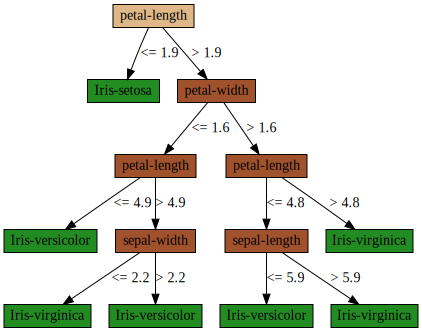

In [23]:
g = clf.visualize_tree(tree_iris)
g.render('tree_iris', format='png', view=True)
clf.visualize_tree(tree_iris)

### 🟩 Tree with Pre-pruning

In [24]:
clf = DecisionTreeClassification(min_samples_leaf=5, max_depth=3)
tree_with_pre_pruning = clf.fit(data_train, target)
tree_with_pre_pruning

<DecisionTree>
<DecisionNode feature="petal-length">
  <DecisionBranch value="<= 1.9">
    <LeafNode label="Iris-setosa" count="28" />
  </DecisionBranch>
  <DecisionBranch value="> 1.9">
    <DecisionNode feature="petal-width">
      <DecisionBranch value="<= 1.6">
        <DecisionNode feature="petal-length">
          <DecisionBranch value="<= 4.9">
            <LeafNode label="Iris-versicolor" count="26" />
          </DecisionBranch>
          <DecisionBranch value="> 4.9">
            <LeafNode label="Iris-versicolor" count="1" />
          </DecisionBranch>
        </DecisionNode>
      </DecisionBranch>
      <DecisionBranch value="> 1.6">
        <DecisionNode feature="petal-length">
          <DecisionBranch value="<= 4.8">
            <LeafNode label="Iris-virginica" count="2" />
          </DecisionBranch>
          <DecisionBranch value="> 4.8">
            <LeafNode label="Iris-virginica" count="25" />
          </DecisionBranch>
        </DecisionNode>
      </DecisionBr

### 🟥 Evaluation

In [25]:
valid_accuracy = clf.validate_tree(tree_with_pre_pruning, data_valid)
test_accuracy = clf.validate_tree(tree_with_pre_pruning, data_test)

print(f'Validation Accuracy: {valid_accuracy}')
print(f'Test Accuracy: {test_accuracy}')

Validation Accuracy: 0.9642857142857143
Test Accuracy: 0.9210526315789473


### 🟦 Visualization

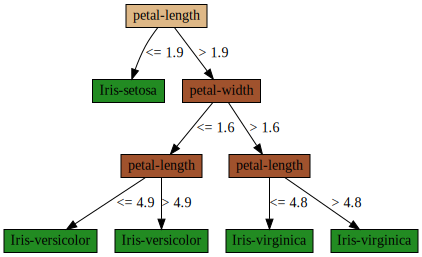

In [26]:
g = clf.visualize_tree(tree_with_pre_pruning)
g.render('tree_with_pre_pruning', format='png', view=True)
clf.visualize_tree(tree_with_pre_pruning)

### 🟩 Tree with Post-pruning

In [27]:
tree_with_post_pruning = clf.post_prune(tree_iris, data_valid, target)
tree_with_post_pruning

<DecisionTree>
<DecisionNode feature="petal-length">
  <DecisionBranch value="<= 1.9">
    <LeafNode label="Iris-setosa" count="28" />
  </DecisionBranch>
  <DecisionBranch value="> 1.9">
    <DecisionNode feature="petal-width">
      <DecisionBranch value="<= 1.6">
        <DecisionNode feature="petal-length">
          <DecisionBranch value="<= 4.9">
            <LeafNode label="Iris-versicolor" count="26" />
          </DecisionBranch>
          <DecisionBranch value="> 4.9">
            <LeafNode label="Iris-virginica" count="1" />
          </DecisionBranch>
        </DecisionNode>
      </DecisionBranch>
      <DecisionBranch value="> 1.6">
        <LeafNode label="Iris-virginica" count="27" />
      </DecisionBranch>
    </DecisionNode>
  </DecisionBranch>
</DecisionNode>
</DecisionTree>

### 🟥 Evaluation

In [28]:
valid_accuracy = clf.validate_tree(tree_with_post_pruning, data_valid)
test_accuracy = clf.validate_tree(tree_with_post_pruning, data_test)

print(f'Validation Accuracy: {valid_accuracy}')
print(f'Test Accuracy: {test_accuracy}')

Validation Accuracy: 1.0
Test Accuracy: 0.9736842105263158


### 🟦 Visualization

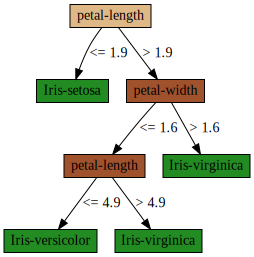

In [29]:
g = clf.visualize_tree(tree_with_post_pruning)
g.render('tree_with_post_pruning', format='png', view=True)
clf.visualize_tree(tree_with_post_pruning)